In [ ]:
# Import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers import Adam

2025-11-01 18:00:58.060398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762020058.083054    2772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762020058.089973    2772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Parameters

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 2
EPOCHS = 100

train_img_path = "/kaggle/input/footulcer/FootUlcer/train/images"
train_mask_path = "/kaggle/input/footulcer/FootUlcer/train/labels"

val_img_path = "/kaggle/input/footulcer/FootUlcer/validation/images"
val_mask_path = "/kaggle/input/footulcer/FootUlcer/validation/labels"

In [ ]:
# Load Images and Masks

In [3]:

def load_data(img_path, mask_path):
    images = []
    masks = []
    img_files = sorted(glob(os.path.join(img_path, "*")))
    mask_files = sorted(glob(os.path.join(mask_path, "*")))

    for img_file, mask_file in zip(img_files, mask_files):
        img = load_img(img_file, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img = img_to_array(img) / 255.0
        images.append(img)

        mask = load_img(mask_file, target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

X_train, Y_train = load_data(train_img_path, train_mask_path)
X_val, Y_val = load_data(val_img_path, val_mask_path)

print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)


Train: (810, 224, 224, 3) (810, 224, 224, 1)
Validation: (200, 224, 224, 3) (200, 224, 224, 1)


In [ ]:
# Data Augmentation

In [5]:
import tensorflow as tf
import numpy as np

# ✅ Replacement for tfa.image.rotate (pure TF)
def tfa_approx_rotate(image, angle, nearest=False):
    """Approximate rotation using affine transform (no TFA dependency)."""
    # Get center of image
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    cx, cy = tf.cast(w / 2, tf.float32), tf.cast(h / 2, tf.float32)

    # Compute rotation matrix around the center
    c = tf.cos(angle)
    s = tf.sin(angle)
    tx = cx - cx * c + cy * s
    ty = cy - cx * s - cy * c

    transform = [c, -s, tx, s, c, ty, 0.0, 0.0]

    return tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, 0),
        transforms=tf.expand_dims(transform, 0),
        output_shape=tf.shape(image)[:2],
        interpolation="NEAREST" if nearest else "BILINEAR",
        fill_value=0.0  # ✅ required for TF ≥ 2.15
    )[0]


# ✅ Full augmentation pipeline
def augment_images(images, masks, num_augments=1):
    augmented_images = []
    augmented_masks = []

    for i in range(len(images)):
        img = tf.convert_to_tensor(images[i], dtype=tf.float32)
        mask = tf.convert_to_tensor(masks[i], dtype=tf.float32)

        for _ in range(num_augments):
            # Random flip
            if tf.random.uniform(()) > 0.5:
                img = tf.image.flip_left_right(img)
                mask = tf.image.flip_left_right(mask)

            # Random rotation (-15° to +15°)
            if tf.random.uniform(()) > 0.5:
                angle = tf.random.uniform((), -0.26, 0.26)
                img = tfa_approx_rotate(img, angle, nearest=False)
                mask = tfa_approx_rotate(mask, angle, nearest=True)

            # Random brightness
            if tf.random.uniform(()) > 0.5:
                img = tf.image.random_brightness(img, max_delta=0.1)

            # Random zoom
            if tf.random.uniform(()) > 0.5:
                scales = tf.random.uniform((), 0.8, 1.0)
                new_size = tf.cast(tf.cast(tf.shape(img)[:2], tf.float32) * scales, tf.int32)
                img = tf.image.resize(img, new_size)
                mask = tf.image.resize(mask, new_size, method="nearest")
                img = tf.image.resize_with_crop_or_pad(img, tf.shape(images[i])[0], tf.shape(images[i])[1])
                mask = tf.image.resize_with_crop_or_pad(mask, tf.shape(images[i])[0], tf.shape(images[i])[1])

            # Random shift (translation)
            if tf.random.uniform(()) > 0.5:
                shift = tf.random.uniform((2,), -0.1, 0.1)
                dx = tf.cast(shift[0] * tf.cast(tf.shape(img)[1], tf.float32), tf.int32)
                dy = tf.cast(shift[1] * tf.cast(tf.shape(img)[0], tf.float32), tf.int32)
                img = tf.roll(img, shift=[dy, dx], axis=[0, 1])
                mask = tf.roll(mask, shift=[dy, dx], axis=[0, 1])

            augmented_images.append(img)
            augmented_masks.append(mask)

    return np.array(augmented_images), np.array(augmented_masks)


# ✅ Example usage
X_train_aug, Y_train_aug = augment_images(X_train, Y_train, num_augments=1)
X_train_final = np.concatenate([X_train, X_train_aug])
Y_train_final = np.concatenate([Y_train, Y_train_aug])

print("After augmentation:", X_train_final.shape, Y_train_final.shape)


After augmentation: (1620, 224, 224, 3) (1620, 224, 224, 1)


In [ ]:
# U-Net Model 

In [13]:
from tensorflow.keras import layers, models

def conv_block(x, filters, kernel_size=3, activation='relu', batchnorm=True):
    """Basic Conv-BN-ReLU block (used throughout the model)."""
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x


def attention_gate(x, g, inter_channels):
    """Fixed attention gate that properly matches spatial shapes."""
    theta_x = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), padding='same')(g)
    up_g = layers.UpSampling2D(size=(K.int_shape(theta_x)[1] // K.int_shape(phi_g)[1],
                                     K.int_shape(theta_x)[2] // K.int_shape(phi_g)[2]),
                               interpolation='bilinear')(phi_g)

    add = layers.Add()([theta_x, up_g])
    act = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(act)
    return layers.Multiply()([x, psi])


def build_attention_unetpp(input_shape=(224, 224, 3), num_classes=1, base_filters=32):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, base_filters)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, base_filters * 2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, base_filters * 4)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, base_filters * 8)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, base_filters * 16)

    # Decoder with dense skip + attention
    g4 = attention_gate(c4, c5, base_filters * 8)
    u4 = layers.UpSampling2D((2, 2))(c5)
    u4 = layers.Concatenate()([u4, g4])
    c6 = conv_block(u4, base_filters * 8)

    g3 = attention_gate(c3, c6, base_filters * 4)
    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.Concatenate()([u3, g3])
    c7 = conv_block(u3, base_filters * 4)

    g2 = attention_gate(c2, c7, base_filters * 2)
    u2 = layers.UpSampling2D((2, 2))(c7)
    u2 = layers.Concatenate()([u2, g2])
    c8 = conv_block(u2, base_filters * 2)

    g1 = attention_gate(c1, c8, base_filters)
    u1 = layers.UpSampling2D((2, 2))(c8)
    u1 = layers.Concatenate()([u1, g1])
    c9 = conv_block(u1, base_filters)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model


# Build and summarize
model = build_attention_unetpp(input_shape=(224, 224, 3), num_classes=1, base_filters=32)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_32[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 112, 112,  │          0 │ activation_33[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_34       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_34[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_35       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 56, 56,    │          0 │ activation_35[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_47[0][0] 

 Total params: 8,120,997 (30.98 MB)

 Trainable params: 8,115,109 (30.96 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [17]:
import tensorflow as tf

# --- Custom Loss: Dice + BCE ---
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

# --- Custom Metric: IoU ---
def iou_coefficient(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# --- Compile Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy', iou_coefficient]
)


In [18]:
# ───────────────────────────────
# Callbacks
# ───────────────────────────────
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callbacks = [
    ModelCheckpoint("best_unet_scratch.h5", save_best_only=True, monitor="val_iou_coef", mode="max"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor="val_iou_coef", patience=8, restore_best_weights=True, mode="max")
]

In [19]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=2,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - accuracy: 0.9465 - iou_coefficient: 0.2532 - loss: 1.2173 - val_accuracy: 0.9888 - val_iou_coefficient: 0.1946 - val_loss: 1.0925 - learning_rate: 1.0000e-04
Epoch 2/100
  3/405 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9831 - iou_coefficient: 0.5870 - loss: 0.8587

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_iou_coef available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_coef` which is not available. Available metrics are: accuracy,iou_coefficient,loss,val_accuracy,val_iou_coefficient,val_loss,learning_rate
  current = self.get_monitor_value(logs)


405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9866 - iou_coefficient: 0.4376 - loss: 0.9575 - val_accuracy: 0.9887 - val_iou_coefficient: 0.4838 - val_loss: 0.8795 - learning_rate: 1.0000e-04
Epoch 3/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9895 - iou_coefficient: 0.4697 - loss: 0.8537 - val_accuracy: 0.9886 - val_iou_coefficient: 0.4741 - val_loss: 0.7643 - learning_rate: 1.0000e-04
Epoch 4/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9908 - iou_coefficient: 0.5158 - loss: 0.7170 - val_accuracy: 0.9933 - val_iou_coefficient: 0.5528 - val_loss: 0.6631 - learning_rate: 1.0000e-04
Epoch 5/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9933 - iou_coefficient: 0.5698 - loss: 0.5904 - val_accuracy: 0.9913 - val_iou_coefficient: 0.5227 - val_loss: 0.5561 - learning_rate: 1.0000e-04
Epoch 6/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9938 - iou_coefficient: 0.6156 - loss: 0.4761 - val_accuracy: 0.9934 - val_iou_coef

In [ ]:
# Test

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ✅ Folder containing 10 test images (make sure this points to the images folder)
image_folder = "/kaggle/input/footulcer/FootUlcer/test/images"

# ✅ Filter only image files (in case of hidden files)
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])[:10]

# Loop through all images
for i, filename in enumerate(image_files):
    img_path = os.path.join(image_folder, filename)
    
    # Load and preprocess image
    img = load_img(img_path, target_size=(224, 224))   # resize to model input
    img_arr = img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)
    
    # Predict mask
    pred = model.predict(img_arr, verbose=0)[0]
    pred = (pred > 0.5).astype(np.uint8)
    
    # Display image and mask
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original: {filename}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
# IoU And Dice accuracy

In [20]:
# Predict on validation set
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(np.uint8)   # thresholding

# IoU
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

# Dice
def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return (2. * intersection) / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) != 0 else 0

# Calculate IoU and Dice for validation set
ious = []
dices = []
for i in range(len(Y_val)):
    ious.append(iou_score(Y_val[i].squeeze(), y_pred[i].squeeze()))
    dices.append(dice_score(Y_val[i].squeeze(), y_pred[i].squeeze()))

print("Mean IoU:", np.mean(ious))
print("Mean Dice:", np.mean(dices))

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 921ms/step
Mean IoU: 0.7306827572279837
Mean Dice: 0.8151337696287712


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


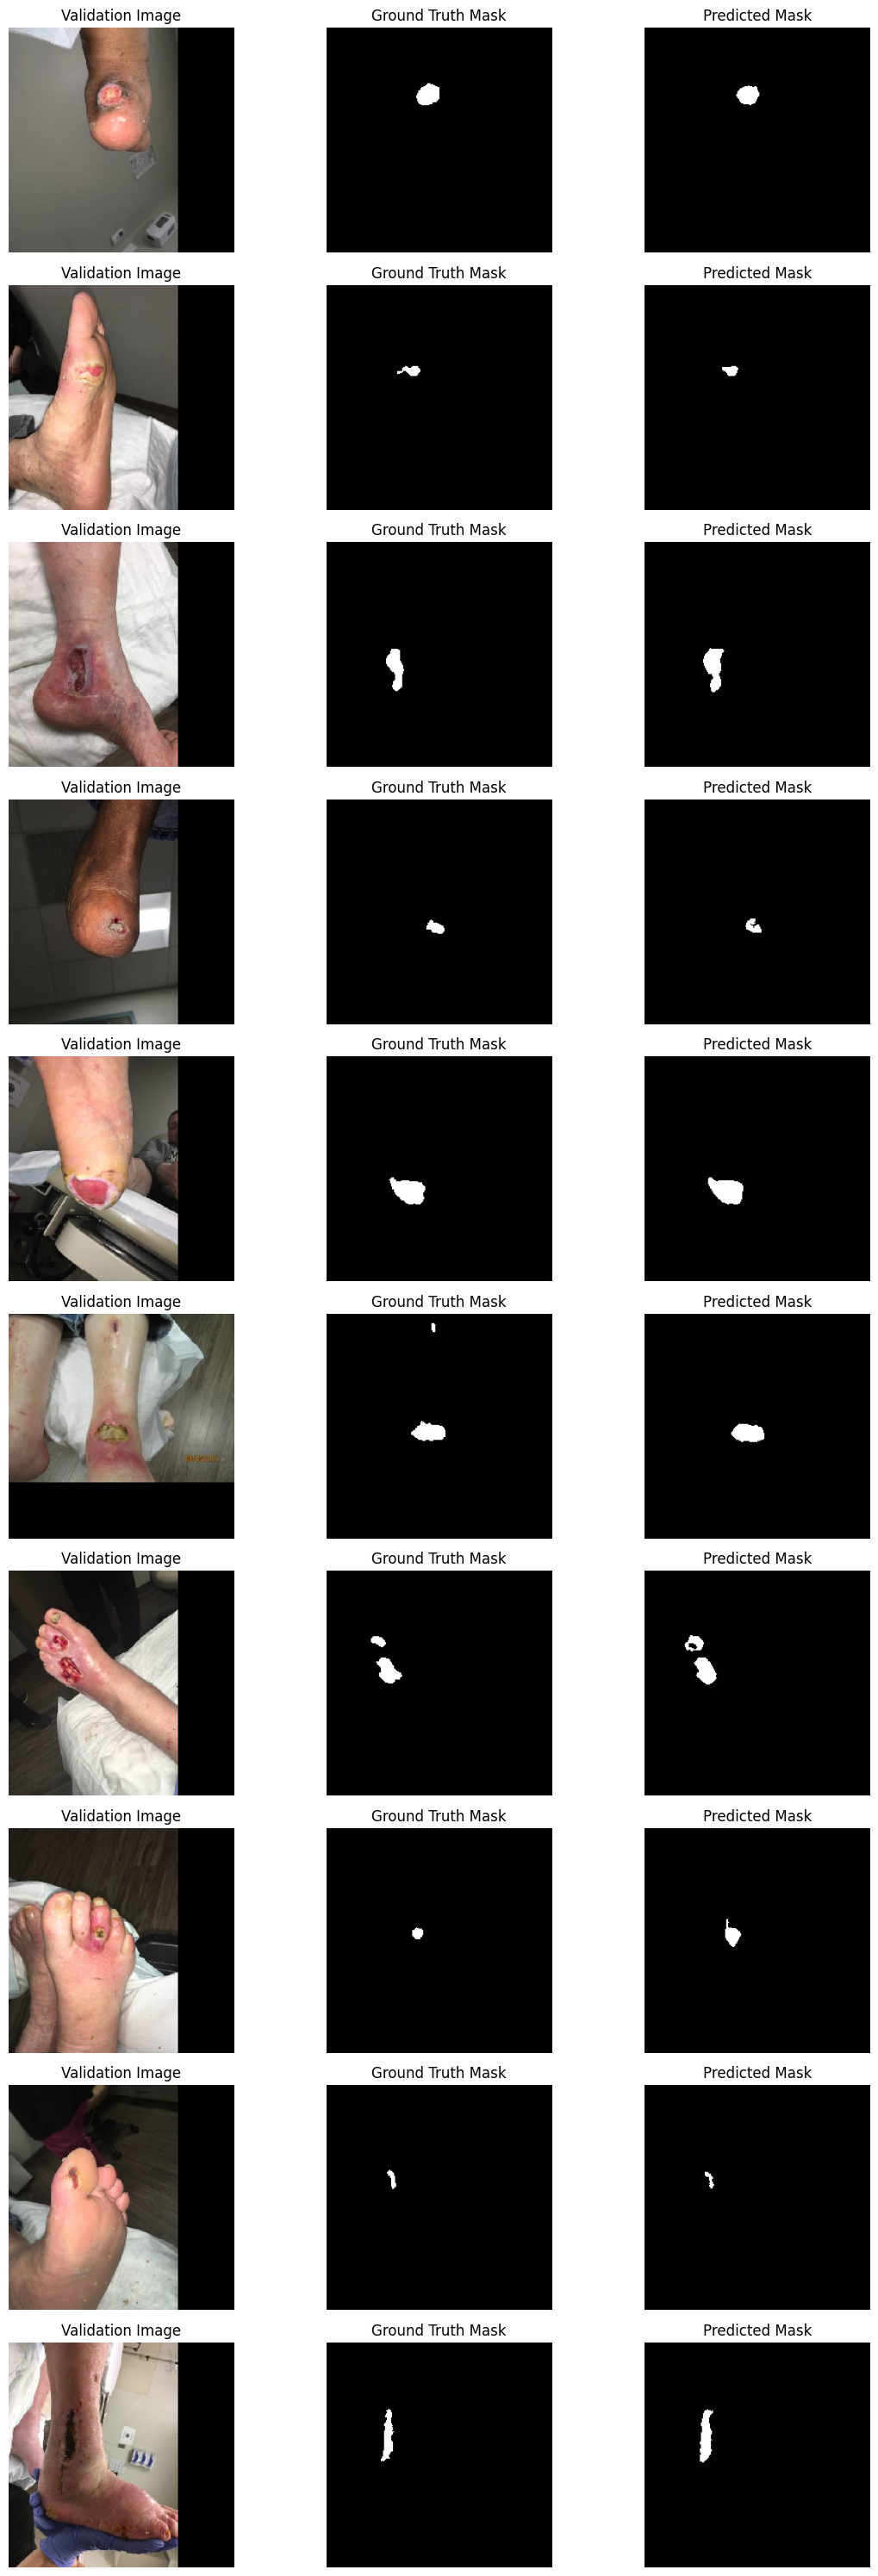

In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# X_val: validation images (N, 224, 224, 3)
# Y_val: corresponding ground truth masks (N, 224, 224, 1)
# model: your trained segmentation model

# Predict on validation set
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)  # threshold to get binary mask

# Select 10 random indices
indices = random.sample(range(len(X_val)), 10)

# Plot
plt.figure(figsize=(12, 30))
for i, idx in enumerate(indices):
    img = X_val[idx]
    gt = Y_val[idx].squeeze()
    pr = preds[idx].squeeze()

    # Original Image
    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(img)
    plt.title("Validation Image")
    plt.axis('off')

    # Ground Truth
    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Prediction
    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(pr, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()
